<a href="https://colab.research.google.com/github/adamserag1/Interpretability-for-VRDU-models/blob/main/Interpretability%20Exp/lime%20(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
Get prediction from pretrained RVL-CDIP model
- load model
- load image
- preprocess image
- get prediction

perform lime on sample for each modality
display
'''

' \nGet prediction from pretrained RVL-CDIP model\n- load model \n- load image \n- preprocess image \n- get prediction\n\nperform lime on sample for each modality \ndisplay\n'

In [2]:
pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [3]:
!pip install datasets seqeval evaluate transformers torch pytesseract lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from PIL import Image, ImageDraw, ImageFont
import evaluate
from transformers import AutoProcessor, LayoutLMv3ForSequenceClassification, set_seed
from datasets import load_dataset
import transformers as t
import torch
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


set_seed(0)

In [5]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("gordonlim/layoutlmv3-base-finetuned-rvlcdip")
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.76k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [6]:
mini_rvl   = load_dataset(
    "dvgodoy/rvl_cdip_mini", split="validation"
)


README.md:   0%|          | 0.00/7.63k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/341M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/42.4M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/41.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3200 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/400 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400 [00:00<?, ? examples/s]

In [7]:
sample = mini_rvl[100]
image = sample['image'].convert("RGB")
words = sample['ocr_words']
bboxes = sample['word_boxes']
print(sample.keys())
print(sample['label'])
#sample['image']
# FORM

dict_keys(['image', 'width', 'height', 'category', 'ocr_words', 'word_boxes', 'ocr_paragraphs', 'paragraph_boxes', 'label'])
1


In [8]:
print(len(words))

87


In [9]:
inputs = processor(images=[image], text=[words],boxes=[bboxes], return_tensors="pt")
inputs.to(device)

{'input_ids': tensor([[    0,  1577,   462,   330, 37904,  9963, 34072, 41759, 35900,   525,
           717, 29214,   448, 10760, 38374,  3935,   305, 27027,    90,   250,
         29114, 23093, 33302,  8228,     4,  1021,  5781,  1577,  5330,   347,
          3721,   947,   113,  1301, 29729,  2342,  6316,  3850,   462, 14249,
           118, 10766, 41516,  3850,    35,  5957,  3850,  9993,   381,  1182,
          7073, 34902, 45152,   717, 21703,   359,   250,   257,  7606, 25370,
          3998,  3631,   298,  6006,  9036, 29992,  4001,  6182,  3082,  6006,
           854, 19928,   717,  3121,   108,   449,  3550,   211,  8625,   131,
           221, 35016,  3137, 13878,  4060, 41759,   256, 40086,    35, 18134,
           856,   100,  3623,   368,  6769,  3281,   833,  5550, 30735,  1071,
         36759, 47500,    35, 13091, 14280,  6034,   131, 11623,   268,  8712,
           417,  1215,  2133,   254,   226, 13452,  7618,   226,  4147,  2577,
           178,  1215,   895,  4097,  

In [10]:
with torch.no_grad():
    outputs = model(**inputs)
logits = outputs.logits
predicted_class_id = logits.argmax(-1).item()
model.config.id2label[predicted_class_id]

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
print(logits)

##Text modality

When perturbing text it is important to remeber that vision and layout components must be perturbed aswell, so that the model does not infer the presence of any text

In [28]:
from lime.lime_tabular import LimeTabularExplainer
from tqdm import tqdm
import numpy as np

def make_predict_fn(model, image, boxes, words, tokenizer):
    def predict(z_bin_list):
        outputs = []
        for z_bin in tqdm(z_bin_list, desc="Perturbing and Predicting"):
            # Masked words → UNK or garbage string
            perturbed_words = [
                word if z else "[UNK]"
                for word, z in zip(words, z_bin)
            ]
            # Masked boxes → zero box
            perturbed_boxes = [
                box if z else [0, 0, 0, 0]
                for box, z in zip(boxes, z_bin)
            ]
            encoding = tokenizer(
                text=[perturbed_words],
                boxes=[perturbed_boxes],
                images=[image],
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=128,
            )
            with torch.no_grad():
                logits = model(**encoding).logits
                probs = torch.softmax(logits, dim=-1).cpu().numpy()
                outputs.append(probs[0])
        return np.array(outputs)
    return predict

num_tokens = len(words)

# Explainer
explainer = LimeTabularExplainer(
    training_data=np.ones((1, num_tokens)),   # dummy input to set feature space
    feature_names=words,                      # each word is a named feature
    class_names=["other", "target_label"],    # change to your actual labels
    mode="classification"
)

# Fix your predict function to take binary mask input
predict_fn = make_predict_fn(model, image, bboxes, words, processor)

# Explain the instance: we use a vector of all 1s (keep all words) as the reference
explanation = explainer.explain_instance(
    data_row=np.ones(num_tokens),         # interpretability vector
    predict_fn=predict_fn,
    num_features=87,
    num_samples=2000
)

Perturbing and Predicting:   0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1614: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Perturbing and Predicting: 100%|██████████| 2000/2000 [06:21<00:00,  5.24it/s]


In [25]:
weights_dict = dict(explanation.as_list())

for word, weight in explanation.as_list():
  print(f"{word:10s} -> {weight:+.3f}")

Xlkoros <= 1.00 -> +0.000
BOOTH TEST DATA <= 1.00 -> +0.000
ZE <= 1.00 -> +0.000
SUMMARY SHEET <= 1.00 -> +0.000
WNLtA <= 1.00 -> +0.000
305 <= 1.00 -> +0.000
PROJECT NO. <= 1.00 -> +0.000
ouy <= 1.00 -> +0.000
XEMCEL&"ZHo <= 1.00 -> +0.000
flbnLEl <= 1.00 -> +0.000
AxiLa <= 1.00 -> +0.000
TITLE: <= 1.00 -> +0.000
TyLEEE Eutux Ae{Eacs <= 1.00 -> +0.000
&Au <= 1.00 -> +0.000
%LuclaxhLL <= 1.00 -> +0.000
DA <= 1.00 -> +0.000
Ouihzi IILL <= 1.00 -> +0.000
YeadEster' k <= 1.00 -> +0.000
44 <= 1.00 -> +0.000
DATE; <= 1.00 -> +0.000


In [24]:
print(explanation.as_list())

[('Xlkoros <= 1.00', 0.0), ('BOOTH TEST DATA <= 1.00', 0.0), ('ZE <= 1.00', 0.0), ('SUMMARY SHEET <= 1.00', 0.0), ('WNLtA <= 1.00', 0.0), ('305 <= 1.00', 0.0), ('PROJECT NO. <= 1.00', 0.0), ('ouy <= 1.00', 0.0), ('XEMCEL&"ZHo <= 1.00', 0.0), ('flbnLEl <= 1.00', 0.0), ('AxiLa <= 1.00', 0.0), ('TITLE: <= 1.00', 0.0), ('TyLEEE Eutux Ae{Eacs <= 1.00', 0.0), ('&Au <= 1.00', 0.0), ('%LuclaxhLL <= 1.00', 0.0), ('DA <= 1.00', 0.0), ('Ouihzi IILL <= 1.00', 0.0), ("YeadEster' k <= 1.00", 0.0), ('44 <= 1.00', 0.0), ('DATE; <= 1.00', 0.0)]


In [27]:
full_mask = np.ones(len(words))  # all 1s = keep everything
full_probs = predict_fn([full_mask])[0]

# Predict with all tokens masked
empty_mask = np.zeros(len(words))  # all 0s = mask all tokens
empty_probs = predict_fn([empty_mask])[0]

print("Full input prediction:", full_probs)
print("All-masked input prediction:", empty_probs)
print("Difference:", np.abs(full_probs - empty_probs).sum())

Perturbing and Predicting: 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]

Full input prediction: [2.1901284e-04 9.2133623e-01 4.5980578e-05 9.8990400e-05 4.9691171e-05
 7.4820034e-02 3.8980160e-04 3.0626764e-04 5.7561661e-04 7.5134325e-05
 1.8726730e-04 3.3002891e-04 3.0664058e-04 7.1659399e-04 1.8051361e-04
 3.6211291e-04]
All-masked input prediction: [4.8096786e-04 4.6189061e-01 4.2227845e-04 2.0163483e-03 2.5223265e-03
 2.6336229e-01 3.7772942e-03 8.3085541e-03 2.6156008e-03 1.7819880e-02
 4.3439597e-02 7.5034578e-03 3.5803687e-02 1.4709957e-01 6.1609084e-04
 2.3214642e-03]
Difference: 0.9188913


⚠️ No valid LIME weights to draw.


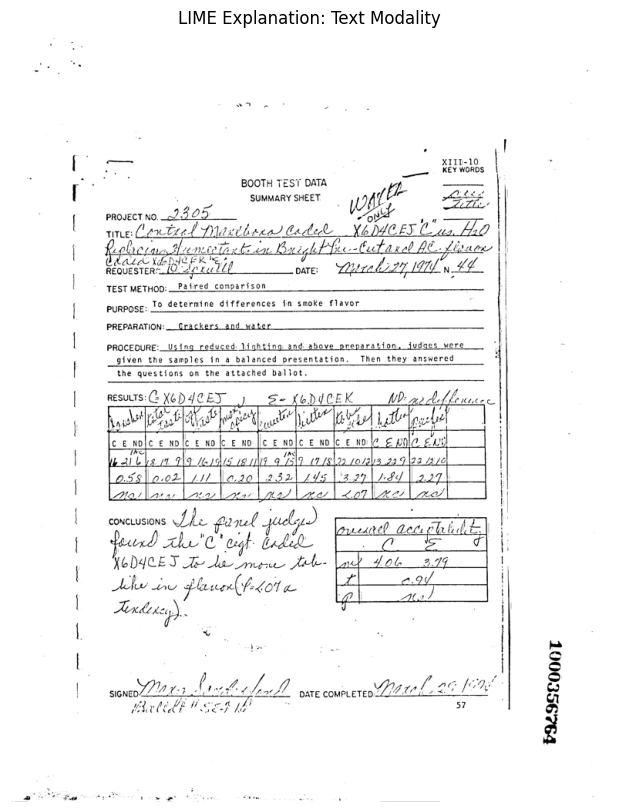

In [17]:
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt

def draw_lime_boxes(image, words, boxes, weights_dict):
    """
    Draws bounding boxes with color-coded weights from LIME.
    Red = positive influence, Blue = negative
    """
    draw = ImageDraw.Draw(image)

    if not weights_dict or all(w == 0 for w in weights_dict.values()):
      print("⚠️ No valid LIME weights to draw.")
      return image  # return original image unchanged

    max_weight = max(abs(w) for w in weights_dict.values()) if weights_dict else 1

    for word, box in zip(words, boxes):
        weight = weights_dict.get(word, 0.0)
        norm_weight = abs(weight) / max_weight
        alpha = int(255 * norm_weight)
        if weight > 0:
            color = (255, 0, 0, alpha)  # red
        else:
            color = (0, 0, 255, alpha)  # blue
        draw.rectangle(box, outline=color, width=3)
        draw.text((box[0], box[1]), word, fill=color)
    return image

# Call the function
highlighted_image = draw_lime_boxes(image.copy(), words, bboxes, weights_dict)

# Show in notebook
plt.figure(figsize=(12, 10))
plt.imshow(highlighted_image)
plt.axis('off')
plt.title("LIME Explanation: Text Modality")
plt.show()